In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('./src')

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
%matplotlib inline

from hyperspherical_vae.distributions import VonMisesFisher
from score_est import Sn, transformed_energy, riem_ld

W0703 20:30:51.632272 140465040422720 deprecation.py:323] From /home/ziyu/wmvl-release/hyperspherical_vae/distributions/von_mises_fisher.py:245: RegisterKL.__init__ (from tensorflow.python.ops.distributions.kullback_leibler) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


## 1D experiment

In [2]:
# ground truth distribution
MEAN = tf.placeholder_with_default(tf.constant([[0., 1.], [.5, -.5]]), [2, 2])
SD = tf.placeholder_with_default(tf.constant([2., 3.]), [2])
MEAN = MEAN / (tf.reduce_sum(MEAN**2, axis=-1, keepdims=True) ** 0.5)
MIXTURE_PROP_1 = 0.7

def true_energ_func(y):
    lp1 = VonMisesFisher(MEAN[0], SD[0]).log_prob(tf.cast(y, tf.float32))
    lp2 = VonMisesFisher(MEAN[1], SD[1]).log_prob(tf.cast(y, tf.float32))
    return -tf.log(tf.exp(lp1)*MIXTURE_PROP_1 + tf.exp(lp2)*(1-MIXTURE_PROP_1))

def to_polar(x):
    return np.arctan2(x[:,1], x[:,0])

In [3]:
sess = tf.InteractiveSession()
# gen training set
N_SAMPLES = 50000
s1 = VonMisesFisher(MEAN[0], [SD[0]]).sample(N_SAMPLES)
s2 = VonMisesFisher(MEAN[1], [SD[1]]).sample(N_SAMPLES)
swc = tf.to_float(tf.random_uniform(shape=[N_SAMPLES]) < MIXTURE_PROP_1)[:,None]
sample_op = swc*s1 + (1-swc)*s2
inp = sess.run(sample_op)

W0703 20:30:52.149364 140465040422720 deprecation.py:323] From /home/ziyu/wmvl-release/hyperspherical_vae/distributions/von_mises_fisher.py:103: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0703 20:30:52.192765 140465040422720 deprecation.py:323] From /home/ziyu/anaconda3/envs/svae/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0703 20:30:52.293278 140465040422720 deprecation.py:323] From /home/ziyu/wmvl-release/hyperspherical

In [4]:
class EnergyNet:
    
    def __init__(self, name):
        self.name = name
    
    def forward(self, inp):
        self.xdims = int(inp.shape[-1])
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
            hid = tf.layers.dense(inp, 100, activation=tf.nn.tanh)
            hid = tf.layers.dense(hid, 100, activation=tf.nn.tanh)
            self.score_prim = tf.layers.dense(hid, self.xdims, activation=None)
        return tf.reduce_sum(self.score_prim*inp, axis=-1, keepdims=True)

In [5]:
inp_ph = tf.placeholder(dtype=tf.float32, shape=[None,2], name='inp')
stepsz_ph = tf.placeholder(dtype=tf.float32, shape=[], name='ssz')

enet = EnergyNet('enet_1d')
def energ_embed(y):
    return enet.forward(y)

_x_neg, ediff, _ = riem_ld(sample_op, energ_embed, stepsz_ph, Sn, tf.to_float(0.5))
mvl_loss = tf.reduce_mean(-ediff) / stepsz_ph
train_op = tf.train.RMSPropOptimizer(learning_rate=5e-4).minimize(mvl_loss)
sess.run(tf.global_variables_initializer())

W0703 20:30:53.209816 140465040422720 deprecation.py:323] From <ipython-input-4-c81d1533b91c>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0703 20:30:53.215525 140465040422720 deprecation.py:506] From /home/ziyu/anaconda3/envs/svae/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0703 20:30:53.676219 140465040422720 deprecation_wrapper.py:119] From ./src/score_est.py:64: The name tf.log is deprecated. Please use tf.math.log instead.

W0703 20:30:53.894444 140465040422720 deprecation_wrapper.py:119] From ./src/score_est.py:103: The name tf.random_normal is deprecated. Please use tf.random.normal instead

In [6]:
ls = []
for j in trange(3000):
    lss, _ = sess.run([mvl_loss, train_op], {inp_ph: inp, stepsz_ph: 1e-5})
    ls.append(lss)

100%|██████████| 3000/3000 [02:21<00:00, 21.14it/s]


W0703 20:33:17.257334 140465040422720 deprecation.py:323] From /home/ziyu/wmvl-release/hyperspherical_vae/ops/ive.py:34: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


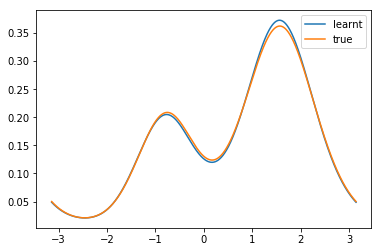

In [7]:
x_grid = x_polar = np.linspace(-np.pi, np.pi, 5000)[:, None]
x_grid = np.concatenate([np.cos(x_grid), np.sin(x_grid)], axis=-1)

e_model = sess.run(energ_embed(inp_ph), {inp_ph: x_grid})
pdf_model = np.exp(-e_model)
pdf_model /= pdf_model.mean() * 2 * np.pi  # approx partition function
plt.plot(x_polar, pdf_model, label='learnt')
pdf = sess.run(true_energ_func(inp_ph), {inp_ph: x_grid})
plt.plot(x_polar, np.exp(-pdf), label='true')
plt.legend()

## 2D

In [8]:
np.random.seed(23)
K = 4
mean = np.random.normal(size=(K, 3))
mean = (mean / ((mean**2).sum(axis=-1)**0.5)[:,None]).astype('f')
sd = np.sqrt(np.random.uniform(1, 50, size=(K,)).astype('f')) + 1e-1
mprop = np.random.uniform(1, 50, size=(K,)).astype('f') ** 2
mprop = mprop / mprop.sum()

MEAN = tf.placeholder_with_default(tf.constant(mean), [mean.shape[0], 3])
SD = tf.placeholder_with_default(tf.constant(sd), [mean.shape[0]])
MEAN = MEAN / (tf.reduce_sum(MEAN**2, axis=-1, keepdims=True) ** 0.5)
MPROP = tf.constant(mprop)

def true_energ_func(y):
    lps = []
    for k in range(K):
        lp = VonMisesFisher(MEAN[k], SD[k]).log_prob(tf.cast(y, tf.float32))
        lps.append(tf.exp(lp) * MPROP[k])
    return -tf.log(tf.add_n(lps))

N_SAMPLES = 50000
spl = VonMisesFisher(MEAN, tf.tile(SD[:,None], [1, 1])).sample(N_SAMPLES)
sample_op = tf.reduce_sum(
    tf.one_hot(tf.random.categorical(tf.log(MPROP[None]), N_SAMPLES)[0], MPROP.shape[-1])[...,None] * spl,
    axis=1)

Text(0.5, 1.0, 'training samples')

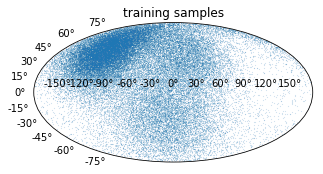

In [9]:
def visualize(arr):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='mollweide')
    lat = np.arctan2((arr[:,1]**2+arr[:,0]**2)**0.5, arr[:,2])
    long = np.arctan2(arr[:,1], arr[:,0])
    lat = np.clip(lat, 0, np.pi-1e-3)
    long = np.clip(long, -np.pi+1e-3, np.pi-1e-3)
    ax.scatter(long, lat-np.pi/2, s=0.005)

inp = sess.run(sample_op)
visualize(inp)
plt.title('training samples')

In [10]:
enet = EnergyNet('enet_2d')
inp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 3], name='inp')
def energ_embed(y):
    return enet.forward(y)

_x_neg, ediff, _ = riem_ld(sample_op, energ_embed, stepsz_ph, Sn, tf.to_float(0.5))
mvl_loss = tf.reduce_mean(-ediff) / stepsz_ph
train_op = tf.train.RMSPropOptimizer(learning_rate=5e-4).minimize(mvl_loss)

In [11]:
sess.run(tf.global_variables_initializer())
ls = []
for j in trange(3000):
    lss, _ = sess.run([mvl_loss, train_op], {inp_ph: inp, stepsz_ph: 1e-5})
    ls.append(lss)

100%|██████████| 3000/3000 [01:06<00:00, 45.31it/s]


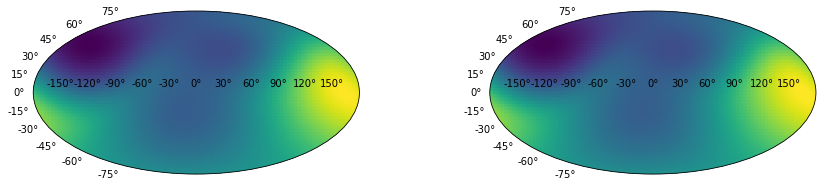

In [12]:
def to_polar_2d(arr):
    lat = np.arctan2((arr[:, 1] ** 2 + arr[:, 0] ** 2) ** 0.5, arr[:, 2])
    long = np.arctan2(arr[:, 1], arr[:, 0])
    return long, lat

def plot_grid_eval(longlat, evals, ax=None):
    long, lat = longlat
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='mollweide')
    ax.hexbin(long, lat-np.pi/2, evals)

x_grid = np.random.normal(size=(400000, 3))
x_grid = x_grid / ((x_grid**2).sum(axis=-1)[:, None] ** 0.5)

logpdf = (-sess.run(true_energ_func(inp_ph), {inp_ph : x_grid}))
e_fitted = sess.run(energ_embed(inp_ph), {inp_ph : x_grid})
fig = plt.figure(figsize=(15, 3), facecolor='w')
ax = fig.add_subplot(121, projection='mollweide')
plot_grid_eval(to_polar_2d(x_grid), e_fitted - e_fitted.mean(), ax)
ax = fig.add_subplot(122, projection='mollweide')
plot_grid_eval(to_polar_2d(x_grid), -logpdf + logpdf.mean(), ax)